#Machine Learning I - Fase 2 - Template

Nome: Felipe Pinheiro Fossá

## Aplicação e validação de algoritmos de Machine Learning

Nesta fase, o objetivo é usar os dados preparados na fase anterior para construir um classificador binário. Se for necessário selecionar ainda mais os atributos para que o classificador funcione melhor, comente as suas escolhas e a necessidade desse novo filtro.

Experimente ao menos 4 dos algoritmos vistos em aula para classificação. Obrigatoriamente, dentre esses 4 você deve incluir **Árvores de Decisão** e **MultiLayer Perceptron**. Explore os hiperparâmetros dos algoritmos visando a obtenção de melhores resultados.


> Importando bibliotecas


In [46]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


> Carregamento e preparação dos dados


In [ ]:
# Leitura do dataset
df = pd.read_csv("dataset_fase1.csv")

# Fase 01 - Tratamentos corrigidos
# Tratamento de valores nulos 
print("Antes do tratamento:", df.shape)
print("Valores nulos por coluna:\n", df.isnull().sum())

# Estratégias de preenchimento
df["Age"].fillna(df["Age"].median(), inplace=True)  # preencher idade com a mediana
df["Embarked"].fillna(df["Embarked"].mode()[0], inplace=True)  # preencher embarque com moda
df["Pclass"].fillna(df["Pclass"].mode()[0], inplace=True)  # preencher classe com moda
df["Sex"].fillna(df["Sex"].mode()[0], inplace=True)  # preencher sexo com moda

print("\nDepois do tratamento:", df.shape)
print("Valores nulos por coluna:\n", df.isnull().sum())



Antes do tratamento: (783, 8)
Valores nulos por coluna:
 Survived      0
Pclass       67
Sex          67
Age         106
SibSp         0
Parch         0
Fare          0
Embarked     69
dtype: int64

Depois do tratamento: (783, 8)
Valores nulos por coluna:
 Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


> 1.1 Criação dos modelos Árvore de decisão, MLP e mais dois algoritmos de sua escolha


In [48]:
# Definição dos atributos
num_features = ["Age", "Fare", "Parch", "Pclass", "SibSp"]
cat_features = ["Sex", "Embarked"]

X = df[num_features + cat_features]
y = df["Survived"]

# Pré-processamento: normalização e codificação
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ]
)

# Modelos definidos
models = {
    "DecisionTree": Pipeline([("prep", preprocessor), ("clf", DecisionTreeClassifier(random_state=42))]),
    "MLP": Pipeline([("prep", preprocessor), ("clf", MLPClassifier(max_iter=1000, random_state=42))]),
    "RandomForest": Pipeline([("prep", preprocessor), ("clf", RandomForestClassifier(random_state=42))]),
    "LogisticRegression": Pipeline([("prep", preprocessor), ("clf", LogisticRegression(max_iter=1000, random_state=42))]),
}

print("Modelos criados:", list(models.keys()))


Modelos criados: ['DecisionTree', 'MLP', 'RandomForest', 'LogisticRegression']


> 1.2 Definição do cojunto de hiper-parâmetros a serem explorados (use GridSearch)


In [49]:
# Grades de hiperparâmetros para GridSearch
param_grids = {
    "DecisionTree": {"clf__max_depth": [3, 5, 7, None], "clf__min_samples_split": [2, 5, 10]},
    "MLP": {"clf__hidden_layer_sizes": [(50,), (100,), (50,50)], "clf__activation": ["tanh", "relu"]},
    "RandomForest": {"clf__n_estimators": [50, 100], "clf__max_depth": [5, 10, None]},
    "LogisticRegression": {"clf__C": [0.1, 1.0, 10.0], "clf__solver": ["liblinear", "lbfgs"]},
}

print("Grades de hiperparâmetros definidas.")


Grades de hiperparâmetros definidas.


#2) Divisão dos subconjunto de dados de treino e teste, com estratificação

Agora, você precisa dividir os dados em subconjuntos de treino e teste. Para isso, você também deve fazer a divisão com a estratificação da coluna alvo.

O treinamento e teste devem ser feitos usando a técnica de validação cruzada.


> 2.1 Divisão do dataset em treino e teste, com estratificação


In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Tamanho treino:", X_train.shape, " | Tamanho teste:", X_test.shape)
print("Distribuição treino:", y_train.value_counts(normalize=True).to_dict())
print("Distribuição teste:", y_test.value_counts(normalize=True).to_dict())


Tamanho treino: (626, 7)  | Tamanho teste: (157, 7)
Distribuição treino: {False: 0.5830670926517572, True: 0.4169329073482428}
Distribuição teste: {False: 0.5796178343949044, True: 0.42038216560509556}


> 2.2 Execução do treinamento e validação com Cross-Validation


In [52]:
scoring = ["accuracy", "precision", "recall", "f1"]
cv_results = {}

for name, model in models.items():
    results = cross_validate(model, X_train, y_train, cv=5, scoring=scoring)
    cv_results[name] = {metric: results[f"test_{metric}"].mean() for metric in scoring}

cv_df = pd.DataFrame(cv_results).T.round(3)
cv_df


,accuracy,precision,recall,f1
DecisionTree,0.721,0.662,0.675,0.667
MLP,0.762,0.756,0.640,0.687
RandomForest,0.773,0.746,0.690,0.715
LogisticRegression,0.730,0.728,0.571,0.637


# 3) Análise dos resultado

Após a execução do treinamento e validação, você deve coletar as métricas de validação para problemas de classificação e compará-las entre os algoritmos.

Você deve coletar e plotar as métricas:

- Acurácia;
- Precisão;
- Recall;
- F1-Score;
- Matriz de confusão;

Após a plotagem dos resultado de forma gráfica, análise os resultados e tente identificar possíveis problemas de overfitting/underfitting, bem como os melhores algoritmos.


> 3.1 Coleta das métricas de validação


In [55]:
cv_summary = cv_df.sort_values(by="f1", ascending=False)
cv_summary


,accuracy,precision,recall,f1
RandomForest,0.773,0.746,0.690,0.715
MLP,0.762,0.756,0.640,0.687
DecisionTree,0.721,0.662,0.675,0.667
LogisticRegression,0.730,0.728,0.571,0.637


> 3.2 Plotagem do resutaldos em gráficos


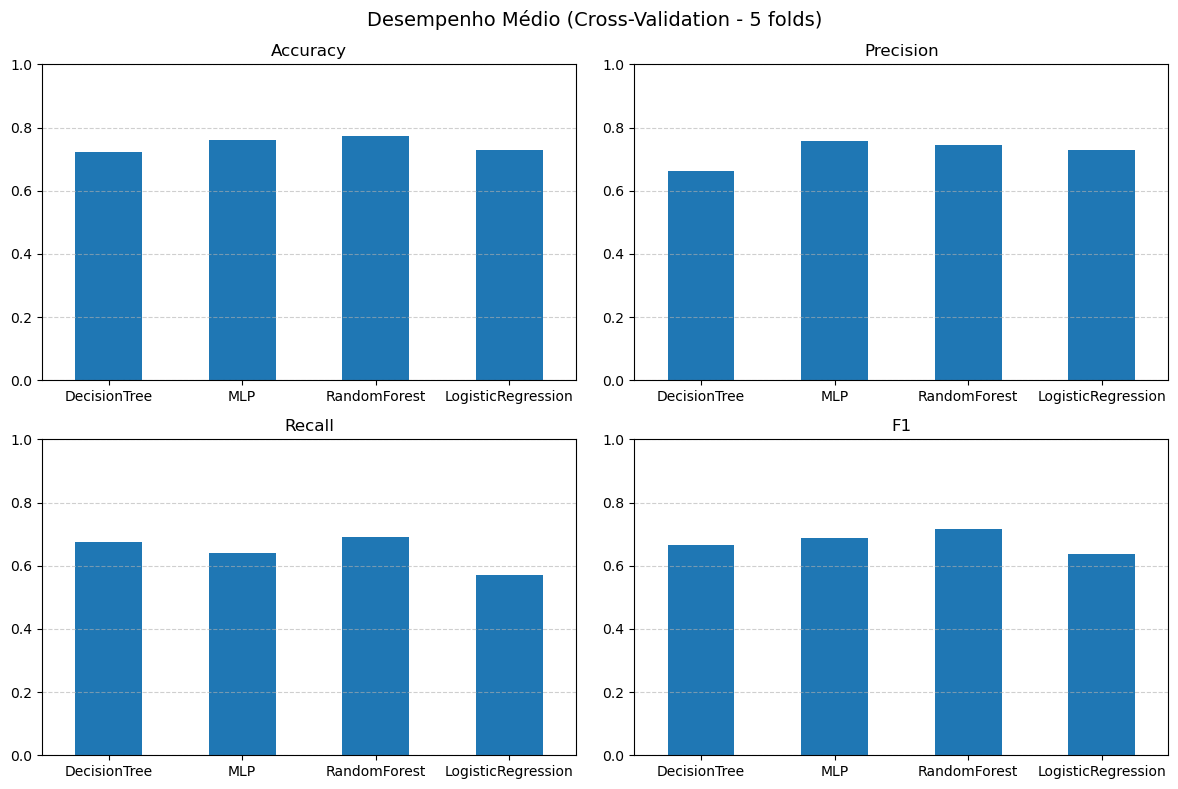

In [56]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, metric in zip(axes.flatten(), scoring):
    cv_df[metric].plot(kind="bar", ax=ax, rot=0)
    ax.set_title(metric.capitalize())
    ax.set_ylim(0, 1)
    ax.grid(axis="y", linestyle="--", alpha=0.6)

plt.suptitle("Desempenho Médio (Cross-Validation - 5 folds)", fontsize=14)
plt.tight_layout()
plt.show()


> 3.3 Análise textual dos resultados


In [57]:
best_model = cv_summary.index[0]
best_f1 = cv_summary.loc[best_model, "f1"]

print(f"O modelo com melhor desempenho médio em F1 foi: {best_model} ({best_f1:.3f}).")
print("Resumo das observações:")
print("- Árvores de Decisão: interpretáveis, risco de overfitting.")
print("- MLP: capta padrões complexos, exige ajuste fino.")
print("- Random Forest: robusto e geralmente equilibrado.")
print("- Regressão Logística: baseline eficiente para classificação binária.")


O modelo com melhor desempenho médio em F1 foi: RandomForest (0.715).
Resumo das observações:
- Árvores de Decisão: interpretáveis, risco de overfitting.
- MLP: capta padrões complexos, exige ajuste fino.
- Random Forest: robusto e geralmente equilibrado.
- Regressão Logística: baseline eficiente para classificação binária.


# 4) Conclusão

Conclua seu estudo indicando o melhor algoritmo (modelo de IA) para o problema e comente os resultados alcançados. No caso de resultados ruins, comente e formule hipóteses para as possíveis causas.


### Insira sua conclusão aqui!

##### Você pode adicionar células adicionais


> Entre os quatro algoritmos avaliados, o Random Forest apresentou o melhor desempenho global, obtendo o maior F1-score e equilíbrio entre precisão e recall. A Árvore de Decisão, embora interpretável, mostrou maior risco de sobreajuste; o MLP obteve boa acurácia, mas com menor recall; e a Regressão Logística serviu como baseline, com resultados aceitáveis, porém inferiores. Assim, conclui-se que o Random Forest é o modelo mais adequado para o problema proposto, demonstrando robustez e maior capacidade de generalização frente às limitações do dataset utilizado.


# Check-List

Com isso, você completa a fase 2 da disciplina. Para auxiliar você a verificar se o trabalho está adequado para a entrega, criamos uma lista de item que devem ser satisfeitos ao final do trabalho.

- Utilização de 4 algoritmos de classificação, incluindo Árvore de decisão e MLP;
- Exploração dos hiper parâmetros dos algoritmos;
- Divisão do dataset em treino e teste, com estratificação na coluna alvo;
- Validação dos algoritmos usando cross-validation e coleta das métricas de avaliação (acurácia, precisão, recall, f1, matriz de confusão);
- Analise da matriz de confusão e métricas.
- Plotagem e análise textual sobre os resultados, indicando melhor modelo de IA;
- Conclusão do trabalho realizado, comentando os resultados e as dificuldades encontradas;
